# 交易系统（Aberration）——趋势跟踪系统股票

## 基本原理

股票价格多围绕某一价格波动，当股票价格原理基准价格超过一定幅度则可能形成长期趋势，而短期股价偏离基准价格过多则可能因过渡偏离均值而形成大幅回测甚至趋势终止
由此以观察期内标准差得一定倍数作为开仓价或止盈价，采用移动止损方式进行止损构建策略
开仓条件
当日最高价 > 均价 + 开仓触发倍数 x 观察期内标准差最大值
止盈条件
当日最高价 > 均价 + 止盈触发倍数 x 观察期内标准差最大值
止损条件
同样结合了移动止损和固定止损两种止损方式
当天最低价 < max(均价， 开仓价 - 止损触发倍数 x 开仓观察期内标准差最大值)
注意
考虑了开仓当天也触发平仓信号得近似处理
用观察期内标准差得最大值开场得原因是：在震荡行情得时候，避免频繁开仓；更加稳定

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tushare as ts
import matplotlib
%matplotlib inline

## 策略实现

### 策略数据处理

In [2]:
code = '002397'
length = 10  #参考周期长度，用于确定计算标准差及移动平均得周期
open_trigger = 0.5  #价格向上偏离均线0.5倍观察期内标准差得最大值开仓
stopwin_trigger = 3  #价格向上偏离均线3倍观察期内标准差最大值止盈
stoplose_trigger = 1  #移动止损条件，跌破均值止损，开仓价向下偏离观察期内标准差得最大值；

In [3]:
data = ts.get_k_data(code, '2012-01-01','2017-01-01')

In [4]:
data.head()

,date,open,close,high,low,volume,code
0,2012-01-04,5.367,5.117,5.367,5.082,1512.0,002397
1,2012-01-05,5.019,4.892,5.019,4.738,3389.0,002397
2,2012-01-06,4.744,4.855,4.877,4.632,4425.0,002397
3,2012-01-09,4.736,4.906,4.916,4.619,2581.0,002397
4,2012-01-10,4.834,5.074,5.082,4.732,2586.0,002397


### 策略数据处理

In [5]:
data['pct_change'] = data['close'].pct_change()   #计算每日收益

In [6]:
data['ma'] = data['close'].rolling(window=length, min_periods=3).mean()   #计算10天得平均收益，最小得计算时间为3天

In [7]:
data['std'] = data['close'].rolling(window=length, min_periods=3).std()  #计算标准差

In [8]:
data.head()

,date,open,close,high,low,volume,code,pct_change,ma,std
0,2012-01-04,5.367,5.117,5.367,5.082,1512.0,002397,NaN,NaN,NaN
1,2012-01-05,5.019,4.892,5.019,4.738,3389.0,002397,-0.043971,NaN,NaN
2,2012-01-06,4.744,4.855,4.877,4.632,4425.0,002397,-0.007563,4.954667,0.141797
3,2012-01-09,4.736,4.906,4.916,4.619,2581.0,002397,0.010505,4.942500,0.118306
4,2012-01-10,4.834,5.074,5.082,4.732,2586.0,002397,0.034244,4.968800,0.118134


In [9]:
data['std_limit'] = data['std'].rolling(window=length).max()   #观察期内标准差最大值

由于当天得实盘数据日线级别参考指标未实现，因此应使用昨日参考指标指导当日交易

In [10]:
data['yes_ma'] = data['ma'].shift(1)
data['yes_std_limit'] = data['std_limit'].shift(1)

计算当日开仓价和止盈价

In [11]:
data['long_open_price'] = data['yes_ma'] + data['yes_std_limit']*open_trigger   #计算每一天满足条件得开仓价

In [12]:
data['long_stopwin_price'] = data['yes_ma'] + data['yes_std_limit']*stopwin_trigger  #计算每一天满足条件得止盈价

In [13]:
data.loc[10:15, ['date','pct_change','ma','std','yes_std_limit','long_open_price','long_stopwin_price']]

,date,pct_change,ma,std,yes_std_limit,long_open_price,long_stopwin_price
10,2012-01-18,-0.021915,4.6869,0.327988,NaN,NaN,NaN
11,2012-01-19,0.033019,4.6357,0.332347,NaN,NaN,NaN
12,2012-01-20,0.017580,4.5959,0.326954,0.332347,4.801873,5.632741
13,2012-01-30,-0.007180,4.5478,0.311270,0.332347,4.762073,5.592941
14,2012-01-31,0.000000,4.4829,0.251235,0.332347,4.713973,5.544841
15,2012-02-01,-0.014011,4.4208,0.180365,0.332347,4.649073,5.479941


计算开仓信号和止盈信号

In [14]:
data['long_open_signal'] = np.where(data['high'] > data['long_open_price'], 1, 0)   #最高价大于开仓价

In [15]:
data['long_stopwin_signal'] = np.where(data['high'] > data['long_stopwin_price'], 1, 0)  #最高价大于止盈价

In [16]:
data[['date','long_open_signal','long_stopwin_signal']].head()

,date,long_open_signal,long_stopwin_signal
0,2012-01-04,0,0
1,2012-01-05,0,0
2,2012-01-06,0,0
3,2012-01-09,0,0
4,2012-01-10,0,0


## 策略逻辑

策略要点：

1，当天有持仓，满足平仓条件惊醒平仓后，当天不再开仓
2，当天无持仓，满足开仓条件之后进行开仓，开仓当日如果同时满足平仓条件，以第二开盘价平仓

In [17]:
flag = 0 #记录持仓情况，1代表持仓，0代表空仓

In [22]:
# 前12个数据因均值计算无效所以不做为待处理数据
# 终止数据选择倒数第二个以防止当天止盈情况会以第二天开盘价平仓导致无数据情况发生
# 最后一天不再进行操作，可能会面临最后一天开仓之后当天触发平仓，要用到下一天开盘价卖出，无法得到

for i in range(12, (len(data) - 1)):
    # 判断持仓条件，有持仓就进行平仓
    if flag == 1:
        #计算止损价格，取均线和开仓价格下移一倍标准差，两者得最大值最为止损价
        stoplose_price = max(
            data.loc[i, 'yes_ma'],
            long_open_price - long_open_delta * stoplose_trigger)
        # 多头止盈并计算当日收益
        if data.loc[i, 'long_stopwin_signal']:
            data.loc[i, 'return'] = data.loc[
                i, 'long_stopwin_price'] / data.loc[i - 1, 'close'] - 1
            flag = 0
        # 多头移动止损，并计算当日收益
        elif data.loc[i, 'low'] < stoplose_price:
            # 考虑当天开盘价下雨止损价，无法止损得情况
            # 考虑实际请情况，采用开盘价和止损价得最小值
            data.loc[i, 'return'] = min(data.loc[i, 'open'], stoplose_price
                                        ) / data.loc[i - 1, 'close'] - 1
            flag = 0

        else:
            #持仓时计算当天得收益
            data.loc[i, 'return'] = data.loc[i, 'close'] / data.loc[
                i - 1, 'close'] - 1

    # 无持仓的操作
    else:
        # 判断是否满足开仓条件
        if data.loc[i, 'long_open_signal']:
            #开仓时标记flag=1
            flag = 1
            #需要比较当天开盘价和开仓价，如果开盘价高于开仓价，只能以开盘价进行开仓，否则会造成收益高估
            #记录开仓价
            #存在跳空高开的情况，有可能取不到long_open_price
            long_open_price = max(data.loc[i, 'open'],
                                  data.loc[i, 'long_open_price'])
            #记录开仓10日内的标准差最大值
            long_open_delta = data.loc[i, 'yes_std_limit']
            #记录开仓当天的收益
            data.loc[i, 'return'] = data.loc[i, 'close'] / long_open_price - 1

            #开仓当天就要计算止损价格，看是否满足止损
            #计算止损价格，多头移动止损，以均线和开仓价减一定倍数标准差，两者的最大值作为止损点
            stoplose_price = max(
                data.loc[i, 'yes_ma'],
                long_open_price - long_open_delta * stoplose_trigger)
            #如果开仓当天同时满足平仓条件，则以第二天开盘价平仓
            #这里做了一个简单的近似处理
            if (data.loc[i, 'low'] < stoplose_price
                    or data.loc[i, 'long_stopwin_signal']):  #满足止损，止盈条件
                #记录此次操作盈利情况并将收益记录在开仓日
                data.loc[i, 'return'] = data.loc[i + 1,
                                                 'open'] / long_open_price - 1
                flag = 0

In [23]:
data.tail()

,date,open,close,high,low,volume,code,pct_change,ma,std,std_limit,yes_ma,yes_std_limit,long_open_price,long_stopwin_price,long_open_signal,long_stopwin_signal,return,strategy_return,stock_return
1200,2016-12-26,7.868,7.927,7.956,7.781,22182.0,002397,0.006220,7.9801,0.080473,0.432141,7.9752,0.432141,8.191270,9.271622,0,0,0.0,2.429878e+102,1.549150
1201,2016-12-27,7.936,7.946,7.985,7.907,14229.0,002397,0.002397,7.9850,0.076231,0.432141,7.9801,0.432141,8.196170,9.276522,0,0,0.0,2.429878e+102,1.552863
1202,2016-12-28,7.936,7.888,7.985,7.859,16192.0,002397,-0.007299,7.9870,0.073014,0.364439,7.9850,0.432141,8.201070,9.281422,0,0,0.0,2.429878e+102,1.541528
1203,2016-12-29,7.859,7.897,7.946,7.859,13150.0,002397,0.001141,7.9772,0.078213,0.259450,7.9870,0.364439,8.169219,9.080317,0,0,0.0,2.429878e+102,1.543287
1204,2016-12-30,7.897,7.878,7.927,7.859,11531.0,002397,-0.002406,7.9577,0.075950,0.228144,7.9772,0.259450,8.106925,8.755551,0,0,0.0,2.429878e+102,1.539574


## 计算策略收益并可视化

In [24]:
data['return'].fillna(0, inplace=True)
data['strategy_return'] = (data['return'] + 1).cumprod()
data['stock_return'] = (data['pct_change'] + 1).cumprod()

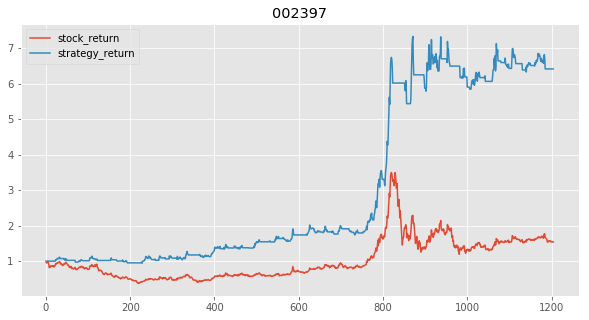

In [25]:
matplotlib.style.use('ggplot')
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(data.stock_return)
ax.plot(data.strategy_return)
plt.title(code)
plt.legend()
plt.show()

## 策略与实盘差异

未考虑滑点

未考虑交易费用

期望开仓价是否执行

期望止损价是否执行